## RAG (Retrieval Augmented Generation)

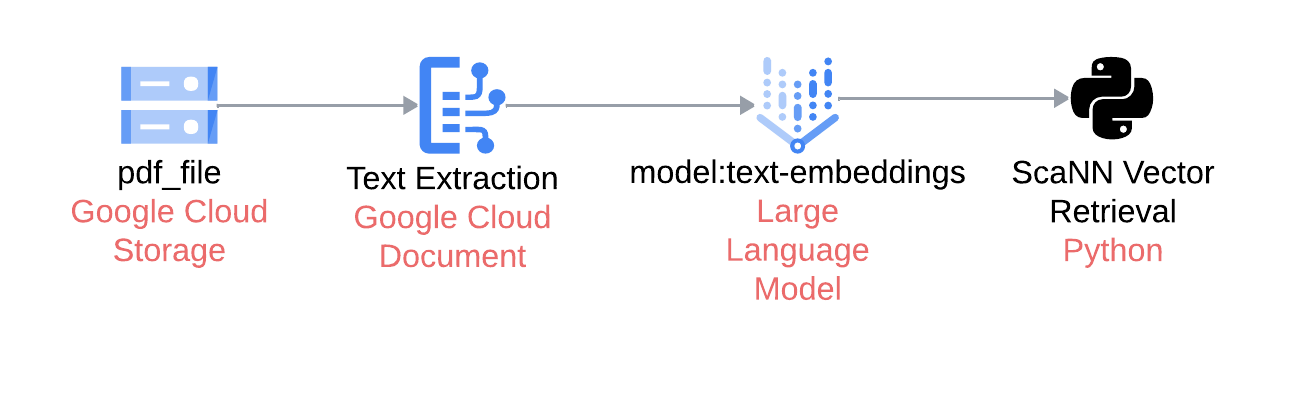

## Requirements
* Install libraries google cloud documentai

In [ ]:
!pip install google-cloud-documentai --upgrade
!pip install google-cloud-storage --upgrade
!pip install PyPDF2
!pip install scann

## Libraries

In [ ]:
import io
import PyPDF2
from google.cloud import documentai, storage

In [ ]:
project_id = "vtxdemos"
file_uri = "gs://vtxdemos-files-private/dwalt-catalogue-2019.pdf"
target_folder_for_split = "dwalt_split/"

# Storage Def

In [ ]:
# File store in Google Cloud Storage (file_uri)
storage_client = storage.Client(project=project_id)
bucket = storage_client.get_bucket(file_uri.split("/")[2])
blob = bucket.blob(file_uri.split("/")[-1])

In [ ]:
from google.api_core.client_options import ClientOptions

client = documentai.DocumentProcessorServiceClient(
    client_options=ClientOptions(
        api_endpoint=f"us-documentai.googleapis.com"
    )
)
name = client.processor_version_path(
      project_id, "us", "1682c8bf8221f616", "pretrained"
  )
# Name: projects/vtxdemos/locations/us/processors/1682c8bf8221f616/processorVersions/pretrained


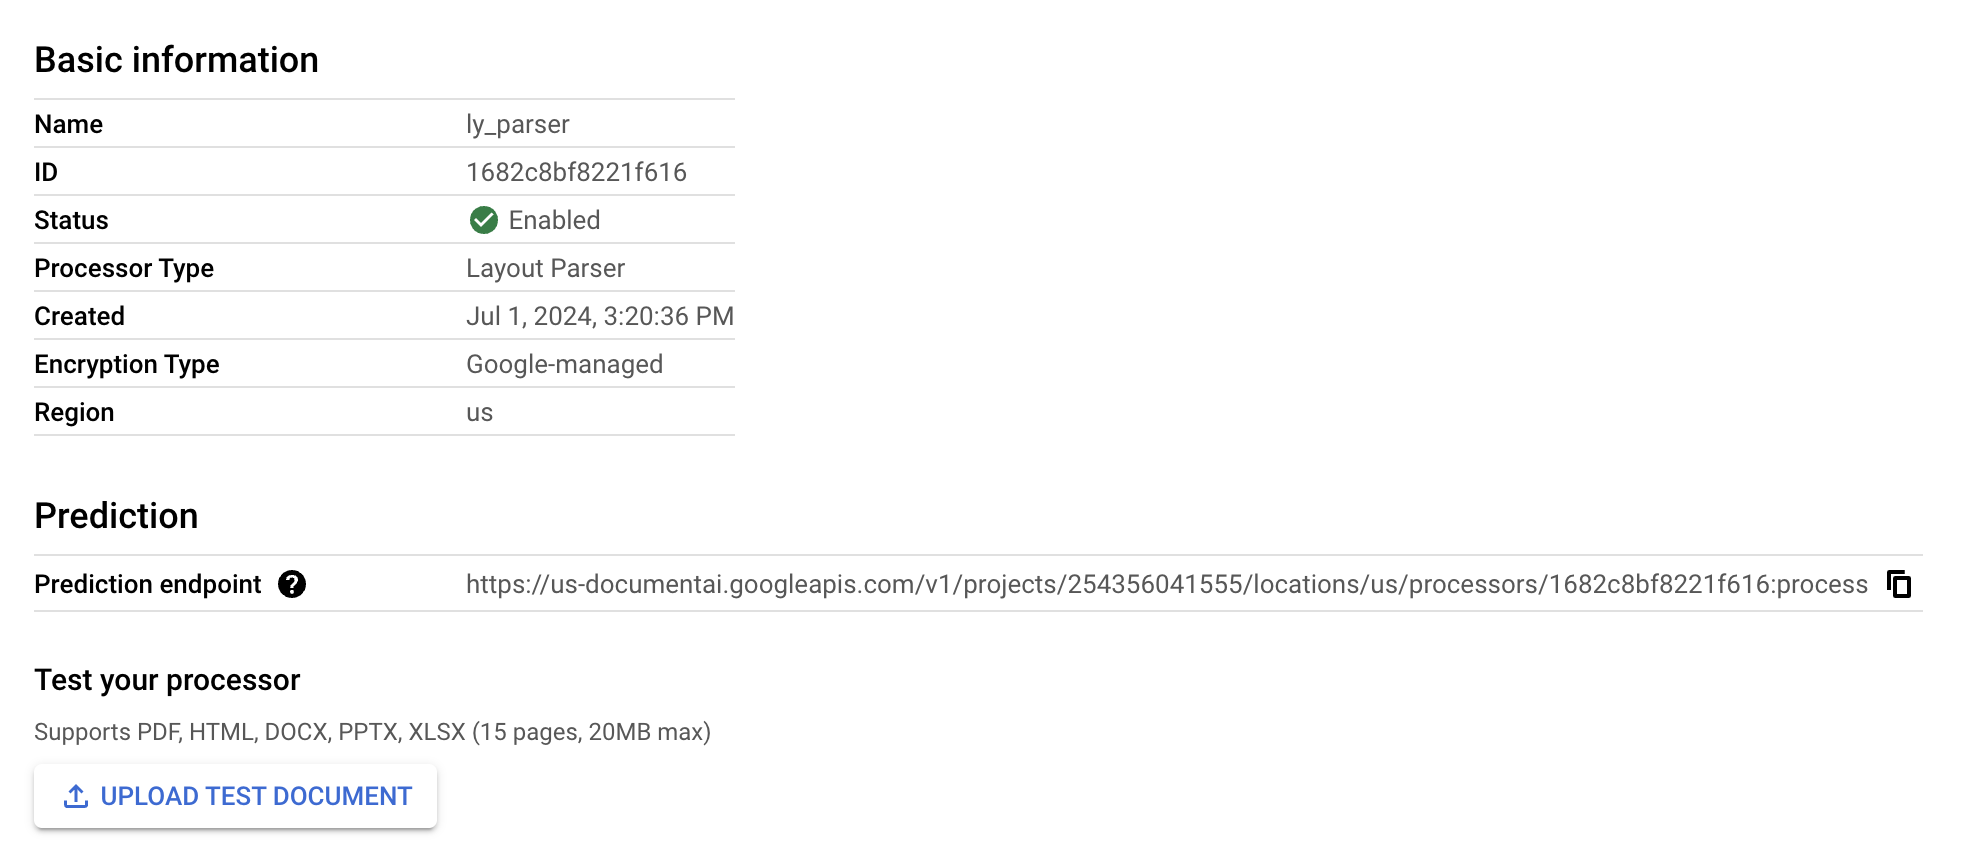

In [ ]:
process_options = documentai.ProcessOptions(
    layout_config=documentai.ProcessOptions.LayoutConfig(
        chunking_config=documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
            chunk_size=1000,
            include_ancestor_headings=True,
        )
    )
)

In [ ]:
contents = blob.download_as_bytes()

request = documentai.ProcessRequest(
    name=name,
    raw_document=documentai.RawDocument(content=contents, mime_type="application/pdf"),
    # Only supported for Document OCR processor
    process_options=process_options,
)

## Spliting File

- Before reading the document, becase the file could potentialy has **many pages** to process, we have to read the documents as bytes and **split** it into pages.

In [ ]:
pdf_bytes = blob.download_as_bytes()
pdf_file = io.BytesIO(pdf_bytes)
pdf_reader = PyPDF2.PdfReader(pdf_file)
num_pages = len(pdf_reader.pages)

# Iterate through each page and save it as a separate file
for page_num in range(num_pages):
    # Create a PDF writer object for the current page
    pdf_writer = PyPDF2.PdfWriter()

    # Add the current page to the writer object
    pdf_writer.add_page(pdf_reader.pages[page_num])

    # Create a file name for the current page
    output_file_name = f'page_{page_num + 1}.pdf'

    # Save the current page as a separate PDF file
    with open(output_file_name, 'wb') as output_file:
        pdf_writer.write(output_file)

## Using Parallelism to Speed up the Reading Process

> Using ThreadPoolExecutor which queues the requests overlaping the threads so the response is faster that doing it in sequence.



In [ ]:
from concurrent.futures import ThreadPoolExecutor
import io
import PyPDF2

def process_page(page_bytes, page_num):
  """Processes a single page using the Document AI API."""
  try:
    # Create an in-memory file-like object from the page bytes
    pdf_file = io.BytesIO(page_bytes)

    request = documentai.ProcessRequest(
        raw_document=documentai.RawDocument(
            content=pdf_file.read(),
            mime_type="application/pdf"
        ),
        name=name,  # Make sure 'name' is defined appropriately
        process_options=process_options,  # ... and 'process_options'
    )
    result = client.process_document(request=request)
    print(f"Processed page {page_num + 1}")
    return result
  except Exception as e:
    print(f"Error processing page {page_num + 1}: {e}")
    return None

def parallel_processing(pdf_bytes):
  """Processes the PDF in parallel, page by page."""

  # Create an in-memory file-like object from the PDF bytes
  pdf_file = io.BytesIO(pdf_bytes)
  pdf_reader = PyPDF2.PdfReader(pdf_file)
  num_pages = len(pdf_reader.pages)

  with ThreadPoolExecutor(max_workers=5) as executor:
    # Submit each page for processing
    futures = []
    for page_num in range(num_pages):
      # Extract the page content as bytes
      pdf_writer = PyPDF2.PdfWriter()
      pdf_writer.add_page(pdf_reader.pages[page_num])
      page_bytes = io.BytesIO()
      pdf_writer.write(page_bytes)
      page_bytes.seek(0)  # Reset the stream position
      futures.append(executor.submit(process_page, page_bytes.read(), page_num))

    # Gather the results (optional)
    results = [future.result() for future in futures]
    return results

# Example usage:
pdf_bytes = blob.download_as_bytes()  # Get your PDF data as bytes
results = parallel_processing(pdf_bytes)

Processed page 1
Processed page 2
Processed page 3
Processed page 5
Processed page 4
Processed page 7
Processed page 6
Processed page 8
Processed page 9
Processed page 10
Processed page 11
Processed page 12
Processed page 13
Processed page 15
Processed page 14
Processed page 16
Processed page 17
Processed page 18
Processed page 19
Processed page 21
Processed page 20
Processed page 22
Processed page 23
Processed page 24
Processed page 26
Processed page 25
Processed page 27
Processed page 28
Processed page 29
Processed page 30
Processed page 31
Processed page 32
Processed page 33
Processed page 34
Processed page 35
Processed page 36
Processed page 37
Processed page 38
Processed page 39
Processed page 40
Processed page 42
Processed page 41
Processed page 44
Processed page 43
Processed page 45
Processed page 46
Processed page 47
Processed page 49
Processed page 50
Processed page 48
Processed page 51
Processed page 52
Processed page 54
Processed page 53
Processed page 55
Processed page 56
P

## Understanding the Extraction

In [ ]:
import pandas as pd

def extract_text_to_dataframe_from_results(results):
    """
    Extracts text from a list of Document AI results (with nested blocks) into a single DataFrame.

    Args:
        results: A list of Document AI ProcessResponse objects.

    Returns:
        A Pandas DataFrame with columns 'page_number', 'block_id', 'text', and 'type'.
    """

    def _extract_blocks(blocks, data, page_number):
        """Recursive function to extract data from nested blocks."""
        for block in blocks:
            block_id = block.block_id
            text = block.text_block.text
            type_ = block.text_block.type_
            data.append({'page_number': page_number, 'block_id': block_id, 'text': text, 'type': type_})
            _extract_blocks(block.text_block.blocks, data, page_number)  # Recursively process nested blocks

    all_data = []
    for page_number, result in enumerate(results):  # Enumerate to get page numbers
        document = result.document
        data = []
        _extract_blocks(document.document_layout.blocks, data, page_number + 1)  # Start page numbers from 1
        all_data.extend(data)

    df = pd.DataFrame(all_data)
    return df

# Assuming 'results' is your list of Document AI ProcessResponse objects
df = extract_text_to_dataframe_from_results(results)
df

,page_number,block_id,text,type
0,1,1,www.DEWALT.com,paragraph
1,2,1,DEWALT,paragraph
2,2,2,www.DEWALT.com,paragraph
3,2,3,POWER TOOLS CATALOGUE,heading-1
4,2,4,SCAN ME!,paragraph
...,...,...,...,...
4403,175,78,,
4404,175,165,,
4405,175,252,174,paragraph
4406,176,1,175,paragraph


In [ ]:
df['text_length'] = df['text'].str.len()
df = df[df['text_length'] >= 20]

def create_unique_id(row):
  """Creates a unique ID by concatenating page_number and block_id."""
  return str(row['page_number']) + str(row['block_id'])

df['unique_id'] = df.apply(create_unique_id, axis=1)
df

<ipython-input-136-7b7fddfef709>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unique_id'] = df.apply(create_unique_id, axis=1)


,page_number,block_id,text,type,text_length,unique_id
3,2,3,POWER TOOLS CATALOGUE,heading-1,21,23
10,3,5,DEWALT® is a market-leading manufacturer of pr...,paragraph,175,35
11,3,6,"DEWALT® tools offer unparalleled performance, ...",paragraph,174,36
23,3,18,"Taking cordless drilling to the next level, th...",paragraph,270,318
24,3,19,With over 100 tools in the range the 18V XR Li...,paragraph,281,319
...,...,...,...,...,...,...
4347,170,24,1/2^{\prime\prime} Female BSP (tool side),paragraph,41,17024
4357,171,2,115-125MM DUST SURFACE GRINDING SHROUD,heading-1,38,1712
4362,171,15,180MM DUST SURFACE GRINDING SHROUD,heading-1,34,17115
4371,172,1,18V LI-ION COMPACT JOBSITE BLOWER,heading-1,33,1721


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


## Embeddings

In [ ]:
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel

emb_model = TextEmbeddingModel.from_pretrained("text-embedding-004")

In [ ]:
def create_embeddings(prompt):
  inputs = [TextEmbeddingInput(prompt, "RETRIEVAL_DOCUMENT")]
  return emb_model.get_embeddings(inputs)[0].values

df['embeddings'] = df.apply(lambda row: create_embeddings(row['text']), axis=1)

<ipython-input-138-130515ff932e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['embeddings'] = df.apply(lambda row: create_embeddings(row['text']), axis=1)


In [ ]:
df

,page_number,block_id,text,type,text_length,unique_id,embeddings
3,2,3,POWER TOOLS CATALOGUE,heading-1,21,23,"[-0.02973252348601818, -0.028264030814170837, ..."
10,3,5,DEWALT® is a market-leading manufacturer of pr...,paragraph,175,35,"[-0.01733025349676609, -0.06455373764038086, -..."
11,3,6,"DEWALT® tools offer unparalleled performance, ...",paragraph,174,36,"[-0.02335924282670021, -0.06919139623641968, 0..."
23,3,18,"Taking cordless drilling to the next level, th...",paragraph,270,318,"[-0.046178873628377914, -0.05701042711734772, ..."
24,3,19,With over 100 tools in the range the 18V XR Li...,paragraph,281,319,"[-0.06529619544744492, -0.022173279896378517, ..."
...,...,...,...,...,...,...,...
4347,170,24,1/2^{\prime\prime} Female BSP (tool side),paragraph,41,17024,"[0.0010906476527452469, 0.015306946821510792, ..."
4357,171,2,115-125MM DUST SURFACE GRINDING SHROUD,heading-1,38,1712,"[-0.047196656465530396, -0.04718223959207535, ..."
4362,171,15,180MM DUST SURFACE GRINDING SHROUD,heading-1,34,17115,"[-0.05244830995798111, -0.04287026822566986, -..."
4371,172,1,18V LI-ION COMPACT JOBSITE BLOWER,heading-1,33,1721,"[-0.057484786957502365, -0.028624042868614197,..."


In [ ]:
# Store DF in GCS
import pickle

with open("file.pkl", "wb") as f:
    pickle.dump(df, f)

storage = bucket.blob("file.pkl")
storage.upload_from_filename("file.pkl")

## RAG Using ScANN

In [ ]:
import scann
import numpy as np

In [ ]:
img = np.array([r["embeddings"] for i, r in df.iterrows()])
k = int(np.sqrt(df.shape[0]))

if int(k/20) < 1:
    leave_search = 1
else:
    leave_search = int(k/20)

In [ ]:
searcher = scann.scann_ops_pybind.builder(img, num_neighbors=5, distance_measure="squared_l2").tree(
    num_leaves=k, num_leaves_to_search=leave_search, training_sample_size=df.shape[0]).score_brute_force(
    2).reorder(7).build()

## Local Test

In [ ]:
 query = "what are the power requirements for FLEXVOLT batteries"
 inputs = [TextEmbeddingInput(query, "RETRIEVAL_DOCUMENT")]
 query_embeddings = emb_model.get_embeddings(inputs)[0].values
 neighbors, distances = searcher.search(query_embeddings, final_num_neighbors=10)

In [ ]:
# prompt: if I have a list like this:  neighbors = array([429, 425, 430,  47, 409, 399, 408], dtype=uint32)
# how can I select the dataframe rows based on their index

selected_rows = df.iloc[neighbors]
print(selected_rows)

      page_number block_id                                               text  \
2700           84       40                  54V 9.0AH LI-ION FLEXVOLT BATTERY   
2662           84        2           54V 6.0AH LI-ION FLEXVOLT BATTERY DCB546   
2702           84       42          54V 12.0AH LI-ION FLEXVOLT BATTERY DCB548   
142             8       36  The only battery on the market that can switch...   
2547           83        3                             12V 2AH LI-ION BATTERY   
2518           80        8                               BATTERIES & CHARGERS   
2546           83        2                               BATTERIES & CHARGERS   

           type  char_count unique_id  text_length  \
2700  paragraph          33      8440           33   
2662  paragraph          40       842           40   
2702  heading-1          41      8442           41   
142   paragraph          62       836           62   
2547  paragraph          22       833           22   
2518  heading-1          20

In [ ]:
import pickle

with open("file.pkl", "wb") as f:
    pickle.dump(df, f)

storage = bucket.blob("file.pkl")
storage.upload_from_filename("file.pkl")

## Using LLM

In [ ]:
import base64
import vertexai
from vertexai.generative_models import GenerativeModel, Part, SafetySetting

In [ ]:
vertexai.init(project="vtxdemos", location="us-central1")

In [ ]:
model = GenerativeModel(
        "gemini-1.5-flash-001",
        system_instruction=["""You are a conversational bot, limit your responses to the context you\'ve been provided."""]
    )
chat = model.start_chat()

In [ ]:
context = [{"page_number": row["page_number"], "text": row["text"]} for index, row in df.iloc[neighbors].iterrows()]

re = chat.send_message(
    f"Context:{str(context)}\n\nQuestion: {query}\nAnswer:"
)

In [ ]:
re.text

'The power requirements for FLEXVOLT batteries are 54V. \n'

## Desing Front End
- Run the following in a google cloud shell or local environment.
- Do not forget to install dependencies:
-- *pip install flet --upgrade*
-- *pip install google-cloud-aiplatform --upgrade*
-- *pip install gcsfs*

In [ ]:
import pickle
import vertexai
import flet as ft
import numpy as np
import pandas as pd
from google.cloud import storage
from vertexai.generative_models import GenerativeModel
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel

# Gemini

project_id = "vtxdemos"

vertexai.init(project=project_id, location="us-central1")
emb_model = TextEmbeddingModel.from_pretrained("text-embedding-004")
model = GenerativeModel(
        "gemini-1.5-flash-001",
        system_instruction=["""You are a conversational bot, limit your responses to the context you\'ve been provided."""]
    )
llm_chat = model.start_chat()
storage = storage.Client(project=project_id)
bucket = storage.get_bucket("vtxdemos-files-private")
pickle_bytes = bucket.blob("file.pkl").download_as_bytes()
df = pickle.loads(pickle_bytes)

img = np.array([r["embeddings"] for i, r in df.iterrows()])

def vector_retrieve(prompt: str):
  inputs = [TextEmbeddingInput(prompt, "RETRIEVAL_DOCUMENT")]
  query_embeddings = emb_model.get_embeddings(inputs)[0].values
  similarities = np.dot(img, query_embeddings) / (np.linalg.norm(img, axis=1) * np.linalg.norm(query_embeddings))
  neighbors = np.argsort(similarities)[-10:][::-1]
  context = [{"page_number": row["page_number"], "text": row["text"]} for index, row in df.iloc[neighbors].iterrows()]
  return str(context)

def main(page: ft.Page):
    page.title = "Simple Chat"

    def send_message(e):
      message = ft.ListTile(
            title=ft.Text(txt_message.value, weight="bold"),
            leading=ft.CircleAvatar(
                content=ft.Text("You"),
                color=ft.colors.WHITE,
                bgcolor=ft.colors.BLUE,
            ),
        )
      chat.controls.append(message)
      chat.update()
      context = vector_retrieve(txt_message.value)
      re = llm_chat.send_message(f"Context:{str(context)}\n\nQuestion: {txt_message.value}\nAnswer:")
      chat.controls.append(
          ft.ListTile(
              title=ft.Text(re.text, weight="bold"),
              leading=ft.CircleAvatar(
                  content=ft.Text("Bot"),
                color=ft.colors.WHITE,
                bgcolor=ft.colors.PINK,
                  )
              )
      )
      chat.update()

    txt_message = ft.TextField(hint_text="Enter your message...", expand=True)
    btn_send = ft.ElevatedButton("Send", on_click=send_message)

    chat = ft.Column(expand=True)

    page.add(
        ft.Column(
            [
                chat,
                ft.Row(
                    [
                        txt_message,
                        btn_send,
                    ],
                ),
            ],
            expand=True,
        )
    )

ft.app(target=main)

In [ ]:
pickle_bytes = bucket.blob("file.pkl").download_as_bytes()
df = pickle.loads(pickle_bytes)

img = np.array([r["embeddings"] for i, r in df.iterrows()])

inputs = [TextEmbeddingInput("batteries", "RETRIEVAL_DOCUMENT")]
query_embeddings = emb_model.get_embeddings(inputs)[0].values
similarities = np.dot(img, query_embeddings) / (np.linalg.norm(img, axis=1) * np.linalg.norm(query_embeddings))

In [ ]:
similarities

In [ ]:
neighbors = np.argsort(similarities)[-10:][::-1]

In [ ]:
neighbors

array([435, 434, 399, 408, 108, 121, 409,  25, 149, 397])